# A Model Transformation-based Workflow

In [2]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.contrib.autoname import scope
from pyro.poutine import condition, reparam

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual

Consider two types of counterfactuals; one of the form:

    Given $X$ was observed as $x$, what would $Y$ have been had $X$ been $x'$,

and another of the form

    Given $X$ was observed as $x$ and $Y$ was observed as $y$, what would $Y$ have been had $X$ been $x'$?.

The former type is potentially identifiable without an SCM using
observational or interventional data [@pearl; @richardson2013single].
*Effect of treatment on the treated* is a useful example of the former
that is widely useful.

The second type of counterfactual is called a
"twin-world counterfactual\" because it predicts $Y$ in a world where we
*do* $X=x'$ conditional on information from a world where $X=x$ already
caused $Y=y$ [@pearl].

Structural counterfactuals enable interesting
counterfactual quantities such as probability of necessity and
sufficiency, and have interesting applications in generative
explanations as well as quantifying regret, blame, and responsibility in
decision theory and agent modeling.

However, inferring twin-world counterfactual counterfactuals require an explicit SCM.
Further, if the SCM is misspecified, it can produce incorrect counterfactual inferences
even if it is a perfect statistical fit for observational and
interventional data.

How do we do select the "right\" surrogate SCM?


## Reparameterization Tricks

A tempting approach is to simply convert a directed generative model
into an SCM using "reparameterization tricks\"
[@kingma2015variational; @jang2016categorical], methods that shunt
randomness to *exogenous* variables to facilitate back-propagation
through *endogenous* variables.

The problem is that in general a causal generative model can yield
different SCMs depending on how it is reparameterized, and the different
SCMs might yield different counterfactual inferences. To illustrate,
consider the following causal generative model.

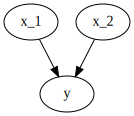

In [8]:
def cgmodel(theta):
    x_1 = pyro.sample("x_1", dist.Bernoulli(0.5))
    x_2 = pyro.sample("x_2", dist.Bernoulli(0.5))
    y = pyro.sample("y", dist.Categorical(probs=theta[..., x_1.long(), x_2.long(), :]))
    return y

pyro.render_model(cgmodel, model_args=(torch.rand(2, 2, 2),))

Suppose we wished to "reparameterize\" this into an SCM. To accomplish
this, we shunt the randomness in the Bernoulli and categorical
distributions to *exogenous* variables $N_{X_1}$, $N_{X_2}$, and $N_{Y}$
through deterministic transformations $f_{X_1}$, $f_{X_2}$, and $f_{Y}$.

In [ ]:
def true_dgp():
    n_x1 = pyro.sample("n_x1", dist.Bernoulli(0.5))
    n_x2 = pyro.sample("n_x2", dist.Bernoulli(0.5))
    n_y = pyro.sample("n_y", dist.Categorical(logits=torch.ones(3)))
    x_1 = f_X1(n_x1)
    x_2 = f_X2(n_x2)
    y = f_Y(x_1, x_2, n_y)
    return y

In this case, $f_{Y,a}$ and $f_{Y,b}$ are two different alternatives for
$f_Y$ above that would each yield the same observational and
interventional distributions:

In [1]:
def f_Ya(x_1, x_2, n_y):
    if x_1 != x_2:
        if n_y == 0:
            return x_1
        else:
            return x_2
    else:
        return n_y

def f_Yb(x_1, x_2, n_y):
    if x_1 != x_2:
        if n_y == 0:
            return x_1
        else:
            return x_2
    else:
        return 2-n_y


However, they would produce different counterfactual inferences. Suppose
we conditioned scmmodel on the observation
$\{X_1 = 1, X_2 = 0, Y = 0 \}$ and we are interested in the
counterfactual query "what would $Y$ have been if $X_1$ had been 0?" 

In this degenerate case, we would infer a point value $N_Y = 0$. When we
re-execute the model after setting both $N_Y$ and $X_1$ to 0, $f_{Y,a}$
would yield 0, and $f_{Y,b}$ would yield 2.

## Monotonicity as Inductive Bias

One solution is to limit ourselves to reparameterizations where key
counterfactual queries are identifiable from observational and
interventional data. [@pearl] named this constraint *monotonicity* and
defined it for the binary outcome case. [@oberst2019counterfactual]
extended the definition to categorical variables and showed that the
Gumbel-softmax reparameterization trick ([@jang2016categorical])
produced a monotonic SCM. [@ness2019integrating] extended the definition
to binomial and Poisson outcomes and provided a probabilistic
programming implementation.

In machine learning, we often talk about the inductive bias of a model,
such as how convolutional neural networks with max-pooling favor
translation invariance. In contrast to inductive biases implicit in
architecture, a strength of the probabilistic programming community is
that we favor explicit inductive biases, i.e. constraining inference
with domain knowledge built into the model.

Monotonicity is an example of an explicit inductive bias. To illustrate,
suppose Anne has the flu but still goes to work. Jon is exposed to Anne
($X_1 = 1$) and and a few days later, Jon got the flu ($Y = 1)$. Jon is
may or may not have had exposure to the flu on the bus ($X_2$), which is
unknown. Given knowledge that Jon was exposed to Anne and he got the
flu, what are the chances he wouldn't have gotten the flu if Anne had
stayed home ($P(Y_{X_1=0}=0|X_1=1, Y=1)$)?

Given sufficient data, we could build a good probabilistic model of
$P(X_1, X_2, Y)$. Theoretically we know that if we were to apply a
monotonic reparameterization (specifically with respect to $X_1$ and
$Y$) to an SCM then we could use that model to infer the above
counterfactual. How would we know if monotonicity is a valid
counterfactual inductive bias in this case?

We can answer with a simple thought experiment. Is it conceivable that
some strange group of coworkers could have the flu, but then *be cured
by* exposure to Anne? That would be a case of non-monotonicity. In this
case that is implausible, and thus monotonicity is a safe assumption.

Suppose, however, that $X_1$ were email promotion and $Y$ were sales,
and we were interested in if John would have bought a product if he
hadn't seen an email promotion. In our thought experiment we would ask
it is plausible for some people who intended to buy a product to be
annoyed enough by an email promotion that they then decided not to buy.
In that case, monotonicity would not be a safe assumption, since
non-monotonicity is plausible.

